"query.bed" was too large to be included in the repo.

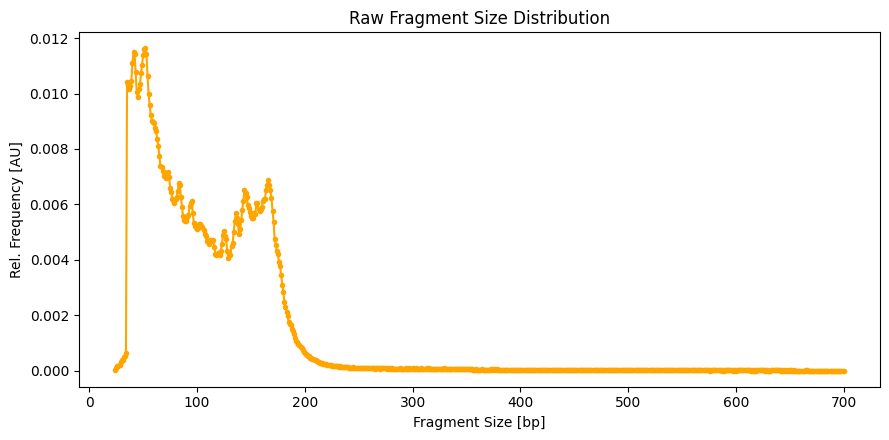

In [31]:
import matplotlib.pyplot as plt

# Reading file & computing the  fragment sizes 
frag_sizes = []

with open('query.bed', 'r') as infile:
    for row in infile:
        cols = row.strip().split()
        if len(cols) >= 3:
            s = int(cols[1])
            e = int(cols[2])
            size = e - s
            if size > 0:
                frag_sizes.append(size)

# frequencies tally
freq_table = {}
for sz in frag_sizes:
    freq_table[sz] = freq_table.get(sz, 0) + 1

# normalizing frequencies
total_counts = sum(freq_table.values())
norm_freqs = {k: v / total_counts for k, v in freq_table.items()}

# sorting for plotting
sorted_freqs = sorted(norm_freqs.items())
x_data = [item[0] for item in sorted_freqs]
y_data = [item[1] for item in sorted_freqs]

# Plot raw distribution
plt.figure(figsize=(9, 4.5))
plt.plot(x_data, y_data, linestyle='-', marker='.', color='Orange')
plt.xlabel("Fragment Size [bp]")
plt.ylabel("Rel. Frequency [AU]")
plt.title("Raw Fragment Size Distribution")
plt.tight_layout()
plt.show()


We can remove breaks and smooth it, for better visibilty

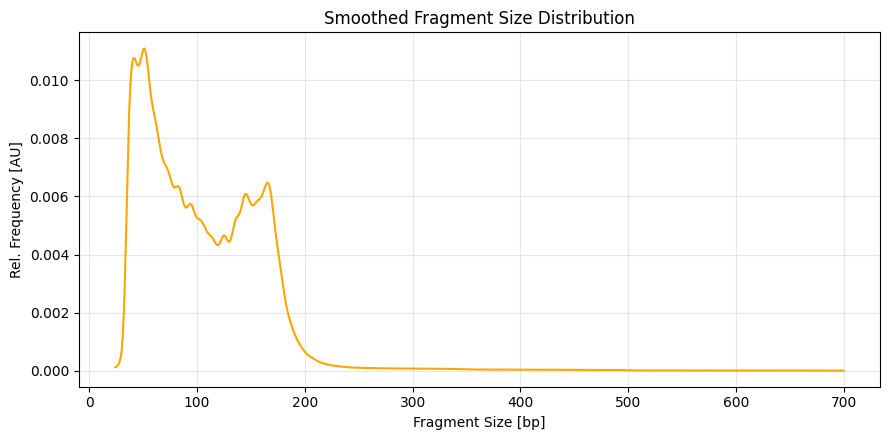

In [33]:
# smoothing here
import numpy as np
from scipy.ndimage import gaussian_filter1d

sorted_items = sorted(freq_table.items())
x_vals = np.array([x[0] for x in sorted_items])
y_vals = np.array([x[1] for x in sorted_items])
y_vals_norm = y_vals / y_vals.sum()


smooth_sigma = 2.5  # smoothing value
smoothed_y = gaussian_filter1d(y_vals_norm, sigma=smooth_sigma)

# plting Plot smoothed curve
plt.figure(figsize=(9, 4.5))
plt.plot(x_vals, smoothed_y, color='orange')
plt.xlabel("Fragment Size [bp]")
plt.ylabel("Rel. Frequency [AU]")
plt.title("Smoothed Fragment Size Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Rescaling


Get the reference.hist in the folder for this

In [34]:
# first load reference histogram
reference_data = {}

with open("reference.hist") as ref_file:
    for entry in ref_file:
        fields = entry.strip().split()
        if len(fields) != 2:
            continue
        l = int(fields[0])
        f = float(fields[1])
        reference_data[l] = f


Computing Query Fragment Lengths

In [35]:
from collections import defaultdict

length_bins = defaultdict(list)

with open("query.bed") as f:
    for line in f:
        cols = line.strip().split()
        if len(cols) < 3:
            continue
        start, end = int(cols[1]), int(cols[2])
        frag_len = end - start
        length_bins[frag_len].append(line)


Query sample matching Reference Histogram

In [36]:
# Resampling based on reference.hist
import random

original_total = sum(len(v) for v in length_bins.values())
target_total = original_total
resampled_lines = []

for l, f in reference_data.items():
    if l in length_bins:
        candidates = length_bins[l]
        draw = min(len(candidates), int(f * target_total))
        resampled_lines.extend(random.sample(candidates, draw))


Plot Comparison of Distributions

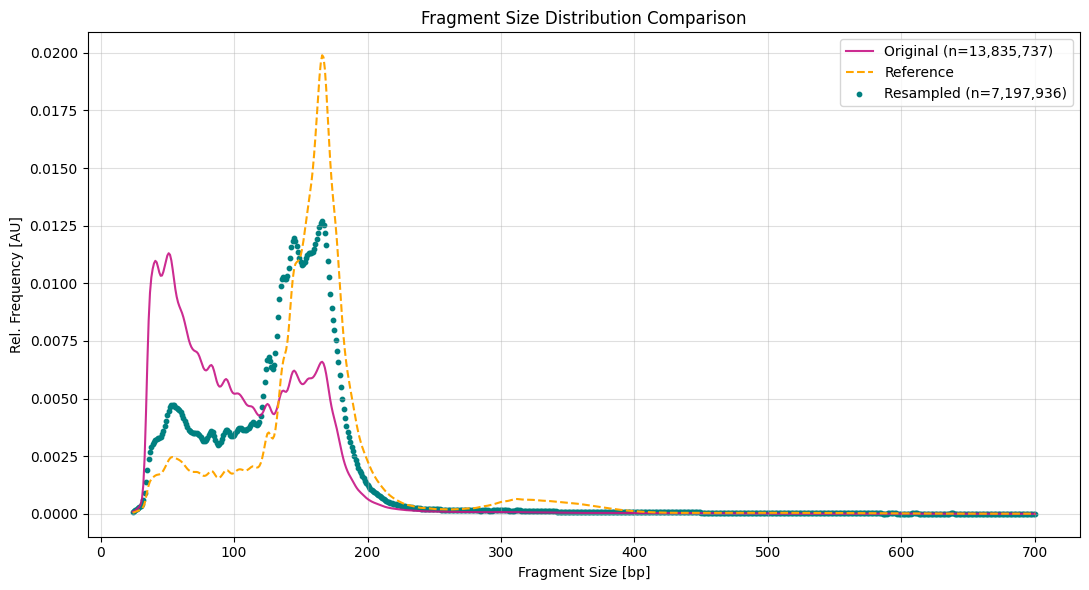

In [38]:
# plot vs Reference vs Resampled Fragment Distributions
from collections import Counter

# flatten lengths
orig_lengths = []
for l, group in length_bins.items():
    orig_lengths.extend([l] * len(group))

resampled_lengths = [
    int(line.strip().split()[2]) - int(line.strip().split()[1])
    for line in resampled_lines
]

# count and nomralize
def normalize_histogram(length_list):
    ct = Counter(length_list)
    total = sum(ct.values())
    return {k: v / total for k, v in ct.items()}

orig_norm = normalize_histogram(orig_lengths)
rescaled_norm = normalize_histogram(resampled_lengths)
ref_norm = reference_data  # already normalized

# align on common x-axis
combined_lengths = sorted(set(orig_norm) | set(rescaled_norm) | set(ref_norm))

def get_y_series(norm_dict):
    return np.array([norm_dict.get(x, 0) for x in combined_lengths])

y_orig = get_y_series(orig_norm)
y_rescaled = get_y_series(rescaled_norm)
y_ref = get_y_series(ref_norm)

# optional smoothing
smooth_sigma = 1.8
y_orig_smooth = gaussian_filter1d(y_orig, sigma=smooth_sigma)
y_rescaled_smooth = gaussian_filter1d(y_rescaled, sigma=smooth_sigma)
y_ref_smooth = gaussian_filter1d(y_ref, sigma=smooth_sigma)

# final Plot
plt.figure(figsize=(11, 6))
plt.plot(combined_lengths, y_orig_smooth, label=f"Original (n={len(orig_lengths):,})", color="mediumvioletred", alpha=0.9)
plt.plot(combined_lengths, y_ref_smooth, label="Reference", color="orange", linestyle='--')
plt.scatter(combined_lengths, y_rescaled_smooth, label=f"Resampled (n={len(resampled_lengths):,})", color="teal", s=10)

plt.xlabel("Fragment Size [bp]")
plt.ylabel("Rel. Frequency [AU]")
plt.title("Fragment Size Distribution Comparison")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
